# Simulationg fibrosis

In [2]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import lil_matrix, diags
import sdeint as sde

import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5
import diffrax
import jax
from jax.experimental import sparse

In [3]:
## Run only if you have installed jax with cuda and there is a GPU in your machine but you anyway want to use the CPU instead 
jax.config.update('jax_platform_name', 'cpu')
# before execute any computation / allocation
print(jax.numpy.ones(3).device)

AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'device'

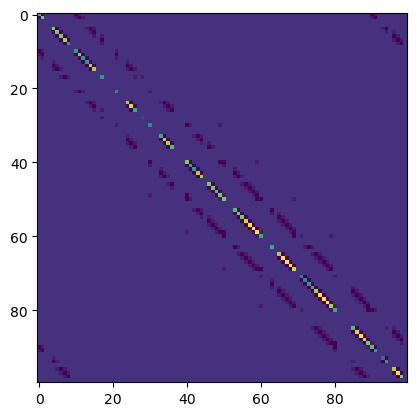

In [7]:

def graph_laplacian(N, M, boundary_condition="periodic", sparse_matrix=True, conduction_block_threshold=0.2):
    """
    Create a graph Laplacian using a 9-point stencil with the option to include conduction blocks.
    Includes support for periodic or von Neumann (no-flux) boundary conditions.
    
    Parameters:
    - boundary_condition: Type of boundary condition ("periodic" or "no-flux").
    - sparse_matrix: Whether to return the Laplacian as a sparse matrix.
    - conduction_block_threshold: Probability threshold for defining conduction blocks. 
      Nodes with random values smaller than this threshold are considered conduction blocks.
    
    """
    
    num_nodes = N * M
    adj_matrix = lil_matrix((num_nodes, num_nodes))  

    # Generate random conduction blocks
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold
    
    def node_index(i, j):
        return i * M + j

    for i in range(N):
        for j in range(M):
            idx = node_index(i, j)
            
            if conduction_blocks[i, j]:
                # Skip this node because it is a conduction block
                continue
            
            # Connect to 8 neighbors (including diagonals), weights according to Oono-Puri
            neighbors = [
                (i - 1, j, .5),     # up
                (i + 1, j, .5),     # down
                (i, j - 1, .5),     # left
                (i, j + 1, .5),     # right
                (i - 1, j - 1, .25), # top-left
                (i - 1, j + 1, .25), # top-right
                (i + 1, j - 1, .25), # bottom-left
                (i + 1, j + 1, .25)  # bottom-right
            ]
            
            for ni, nj, w in neighbors:
                if boundary_condition == "no-flux":
                    # Apply no-flux (Neumann) boundary conditions:
                    if 0 <= ni < N and 0 <= nj < M:
                        if not conduction_blocks[ni, nj]:
                            # Connect only to non-conduction block neighbors inside the grid
                            adj_matrix[idx, node_index(ni, nj)] = w
                
                elif boundary_condition == "periodic":
                    # Apply periodic boundary conditions by wrapping indices
                    ni_wrapped = ni % N
                    nj_wrapped = nj % M
                    if not conduction_blocks[ni_wrapped, nj_wrapped]:
                        adj_matrix[idx, node_index(ni_wrapped, nj_wrapped)] = w

    # Compute degrees (diagonal degree matrix)
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)
    
    # Laplacian: L = D - A
    laplacian_matrix = degree_matrix - adj_matrix
    
    if sparse_matrix:
        return sparse.csr_matrix(laplacian_matrix)  # Return as sparse matrix
    else:
        return laplacian_matrix.todense()  # Return as dense matrix


N_x = 10
N_y = 10
N = N_x*N_y
sparse_matrix = True
laplacian = graph_laplacian(N_x, N_y, boundary_condition="periodic", sparse_matrix=sparse_matrix)
plt.imshow(laplacian.todense())

In [ ]:
#the FHN equations would become
def FHN_graph(t, y, args):
    N, a, b, e, Du, L = args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

In [ ]:
@jax.jit
def solve_heart(y0='center-excitation',a=3,b=0.2,e=1e-2,Du=.1,T=300,L=graph_laplacian(N_x, N_y, sparse_matrix=sparse_matrix), max_steps=1000000, solver=Dopri5(),rtol=1e-3, atol=1e-4,dt0=1e-2):
    if y0 == 'center-excitation':
        y0 = jnp.zeros(2*N)
        center = N//2+N_x//2
        y0 = y0.at[center-1:center+2].set(0.5)
        y0 = y0.at[center-N_x].set(0.5)
        y0 = y0.at[center+N_x].set(0.5)
    
    term = ODETerm(FHN_graph)
    saveat = SaveAt(ts=jnp.linspace(0, T, 100))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    sol = diffeqsolve(term, solver, 0, T, dt0, y0, args=(N,a,b,e,Du, L), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)

In [ ]:
sol = solve_heart(T=1000)
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])